# Marmousi Elastic model

In [15]:
import os
from pathlib import Path
import subprocess
import segyio
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np

## Get the data

In [2]:
!pwd

/Users/filippo/Work/cervino/notebooks


In [3]:
!curl https://s3.amazonaws.com/open.source.geoscience/open_data/elastic-marmousi/elastic-marmousi-model.tar.gz -o marmousi-elastic-model.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  1888k      0  0:01:19  0:01:19 --:--:-- 1181k    0  2353k      0  0:01:03  0:00:38  0:00:25 1410k


In [4]:
!wget https://s3.amazonaws.com/open.source.geoscience/open_data/elastic-marmousi/elastic-marmousi-model.tar.gz

/bin/sh: wget: command not found


In [4]:
!tar -xzvf marmousi-elastic-model.tar.gz

x elastic-marmousi-model/model/
x elastic-marmousi-model/processed_data/SEGY-Time/Kirchhoff_PoSTM_time.segy.tar.gz
x elastic-marmousi-model/processed_data/SEGY-Time/SYNTHETIC_time.segy.tar.gz
x elastic-marmousi-model/model/LAYER_PROPERTIES.pdf
x elastic-marmousi-model/processed_data/SEGY-Depth/SYNTHETIC.segy.tar.gz
x elastic-marmousi-model/processed_data/
x elastic-marmousi-model/processed_data/SEGY-Depth/Kirchhoff_PreSDM.segy.tar.gz
x elastic-marmousi-model/model/FINAL_HORIZONS.asc
x elastic-marmousi-model/model/FINAL_HORIZONS_GX2.asc
x elastic-marmousi-model/processed_data/SEGY-Depth/Kirchhoff_PoSDM.segy.tar.gz
x elastic-marmousi-model/processed_data/SEGY-Time/NMOstack_SRME_time.segy.tar.gz
x elastic-marmousi-model/processed_data/SEGY-Depth/Vs.segy.tar.gz
x elastic-marmousi-model/processed_data/SEGY-Depth/NMOstack.segy.tar.gz
x elastic-marmousi-model/processed_data/SEGY-Depth/WE_PreSDM.segy.tar.gz
x elastic-marmousi-model/reports/
x elastic-marmousi-model/processed_data/SEGY-Time/
x 

In [5]:
!ls marmousi-elastic-model/model

FINAL_HORIZONS.asc                      MODEL_DENSITY_1.25m.segy.tar.gz
FINAL_HORIZONS_GX2.asc                  MODEL_P-WAVE_VELOCITY_1.25m.segy.tar.gz
LAYER_PROPERTIES.pdf                    MODEL_S-WAVE_VELOCITY_1.25m.segy.tar.gz


In [6]:
path = Path(r'marmousi-elastic-model/model')
print(path.resolve())

/Users/filippo/Work/cervino/notebooks/elastic-marmousi-model/model


## Load the data

In [7]:
model_files = path.glob('MODEL*.tar.gz')

for model_file in model_files:
#     print(i.name)
#     model_file = path / 'MODEL_P-WAVE_VELOCITY_1.25m.segy.tar.gz'
#     print(f)
    p = subprocess.run(['tar','-xzvf', model_file, '-C', model_file.parent], stdout=subprocess.PIPE)
    print(p.stdout)

b''
b''
b''


In [9]:
for i in path.glob('MODEL*.segy'):
    print(i)

elastic-marmousi-model/model/MODEL_P-WAVE_VELOCITY_1.25m.segy
elastic-marmousi-model/model/MODEL_S-WAVE_VELOCITY_1.25m.segy
elastic-marmousi-model/model/MODEL_DENSITY_1.25m.segy


In [10]:
# Pay attention to the order.
# It needs to be consistent with path.glob('MODEL*.segy'), see above!
# model_list = {'vs': 'm/s',
#               'rho': 'kg/m^3',
#               'vp': 'm/s'}

model_list = {'vp': 'm/s',
              'vs': 'm/s',
              'rho': 'kg/m^3'}

# Create HDF5 file
with h5py.File('marmousi_elastic_2d.h5', 'w') as f:
    model_group = f.create_group('Models')

    model_files = path.glob('MODEL*.segy')
    for file, model  in zip(model_files, model_list.keys()):
        print(file.name)
        
        if model == 'rho':
            data = segyio.open(file, ignore_geometry=True).trace.raw[:] * 1e3
        else:
            data = segyio.open(file, ignore_geometry=True).trace.raw[:]
        model_group.create_dataset(model, data=data)
    
    # Create geometry group
    geometry_group = f.create_group('Geometry')
    geometry_group.attrs['number-of-cells'] = [13601, 1, 2801]
    geometry_group.attrs['cell-size'] = [1.25, 1.25, 1.25]
    geometry_group.attrs['origin'] = [0.0, 0.0, 0.0]

MODEL_P-WAVE_VELOCITY_1.25m.segy
MODEL_S-WAVE_VELOCITY_1.25m.segy
MODEL_DENSITY_1.25m.segy


In [6]:
with h5py.File('marmousi_elastic_2d.h5', 'r') as f:
    print(f['Geometry'].attrs['cell-size'])
    print(type(f['Geometry'].attrs['cell-size']))

[1.25 1.25 1.25]
<class 'numpy.ndarray'>


## Create binary files for Matterhorn

In [19]:
with h5py.File('marmousi_elastic_2d.h5', 'r') as f:
    dset = f['Models']['vp']
    with dset.astype('float32'):
        print(dset.shape)
        dset[:].tofile('marmousi_elastic_2d_vp.bin')
    dset = f['Models']['vs']
    with dset.astype('float32'):
        print(dset.shape)
        dset[:].tofile('marmousi_elastic_2d_vs.bin')
    dset = f['Models']['rho']
    with dset.astype('float32'):
        print(dset.shape)
        dset[:].tofile('marmousi_elastic_2d_rho.bin')

(13601, 2801)
(13601, 2801)
(13601, 2801)


In [18]:
13601*2801*4

152385604

## Plot models

In [12]:
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

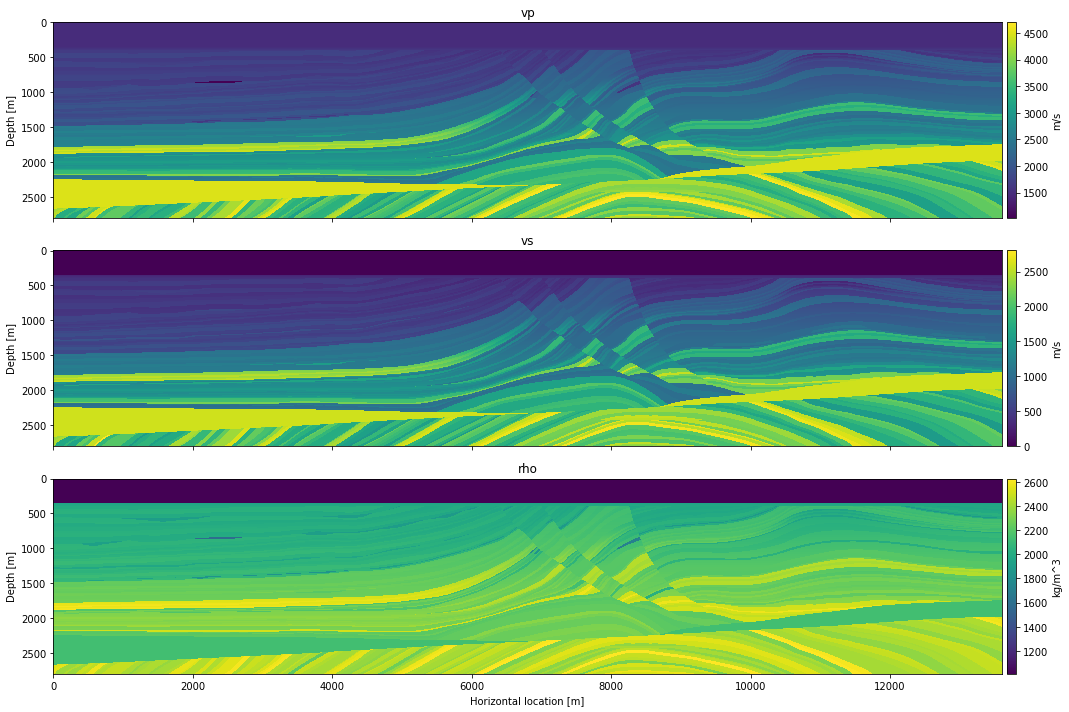

In [13]:
# Set up figure
clip = 1e-1
vmin, vmax = -clip, clip

# Figure
figsize=(15, 10)
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=figsize, facecolor='w', edgecolor='k',
                        squeeze=False,
                        sharex=True)
axs = axs.ravel()
# fig.set_figwidth(20)

im = []
with h5py.File('marmousi_elastic_2d.h5', 'r') as f:
    for i, (model, unit) in enumerate(model_list.items()):
        im.append(axs[i].imshow(f['Models'][model][()].T, cmap=plt.cm.viridis, aspect=1))
        _ = axs[i].set_title(model)
#         _ = axs[i].set_xlabel('Horizontal location [m]')
        _ = axs[i].set_ylabel('Depth [m]')
        cb = add_colorbar(im[i])
        cb.set_label(unit)
#     _ = axs[0].set_xlabel('Depth [m]')
    _ = axs[2].set_xlabel('Horizontal location [m]')
fig.tight_layout()